In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

In [2]:
import logging
logging.basicConfig(level=logging.WARN)

import pathlib
from copy import copy

import gym
# noinspection PyUnresolvedReferences
import gym_grid

from lcs import Perception
from lcs.metrics import population_metrics
from lcs.strategies.action_selection import EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.experiments import avg_experiments
from utils.plotting import COLORS

from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font',**{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 12})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [3]:
from notebooks import get_from_cache_or_run

cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/2020_investigating-exploration-techniques-for-acs-in-discretized-real-valued-environments/cache/'

In [4]:
experiments = 50

explore_trials = 60
exploit_trials = 20

## Environment

In [5]:
grid_size = 20  # 5/10/20/40/100

ENV_NAME = f'grid-{grid_size}-v0'
env = gym.make(ENV_NAME)

In [6]:
# visualization (for grid-size = 20 this is readible)
env.reset()
env.render()


('1', '9')
 19 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 18 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 17 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 16 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 15 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 14 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 13 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 12 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 11 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
 10 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  9 _  X  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  8 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  7 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  6 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  5 _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _  _ 
  4 _  _  _  _  _  _  _  _  

In [7]:
transitions = env.env.get_transitions()

In [8]:
def calculate_knowledge(population, environment):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions) * 100.0

In [9]:
# Build agent configuration
# Collect additional population metrics
def grid_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': calculate_knowledge(pop, env)
    }
    metrics.update(population_metrics(pop, env))
    return metrics

In [10]:
base_params = {
    "classifier_length": 2,
    "number_of_possible_actions": 4,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 1,
    "metrics_trial_frequency": 1,
    "user_metrics_collector_fcn": grid_metrics
}

### Epsilon Greedy (baseline)

In [11]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy

epsilon_greedy_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-epsilon-greedy.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **epsilon_greedy_params))

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x7f435588b9e0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}



Experiment: 100%|██████████| 50/50 [31:09<00:00, 37.39s/it]

CPU times: user 31min 11s, sys: 1.03 s, total: 31min 12s
Wall time: 31min 9s


### Action Delay Bias

In [12]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-action-delay.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **action_delay_params))

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x7f435588b9e0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>}



Experiment: 100%|██████████| 50/50 [30:42<00:00, 36.85s/it]

CPU times: user 30min 45s, sys: 1.72 s, total: 30min 46s
Wall time: 30min 42s


### Knowledge Array Bias

In [13]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-knowledge-array.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **knowledge_array_params))

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x7f435588b9e0>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>}



Experiment: 100%|██████████| 50/50 [42:10<00:00, 50.62s/it]

CPU times: user 42min 10s, sys: 1.24 s, total: 42min 12s
Wall time: 42min 10s


### Optimistic Initial Quality

In [14]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-optimistic-initial-quality.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **op_initial_params))

{'classifier_length': 2, 'number_of_possible_actions': 4, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function grid_metrics at 0x7f435588b9e0>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}



Experiment: 100%|██████████| 50/50 [31:13<00:00, 37.48s/it]

CPU times: user 31min 15s, sys: 1.4 s, total: 31min 16s
Wall time: 31min 13s


Sneak peek into collected metrics

In [15]:
epsilon_greedy_df[:5]

,phase,steps_in_trial,reward,perf_time,knowledge,population,numerosity,reliable
trial,,,,,,,,
0,explore,1361.56,520.0,0.345031,65.193676,72.66,490.52,51.62
1,explore,1250.52,660.0,0.348267,86.505929,83.64,889.62,68.96
2,explore,1247.44,620.0,0.354313,91.209486,84.02,1130.22,73.16
3,explore,910.54,780.0,0.258590,91.943347,83.40,1235.88,73.94
4,explore,1319.66,640.0,0.378904,94.072464,82.84,1363.34,75.90


## Vizualization
### Aggregated performance plot

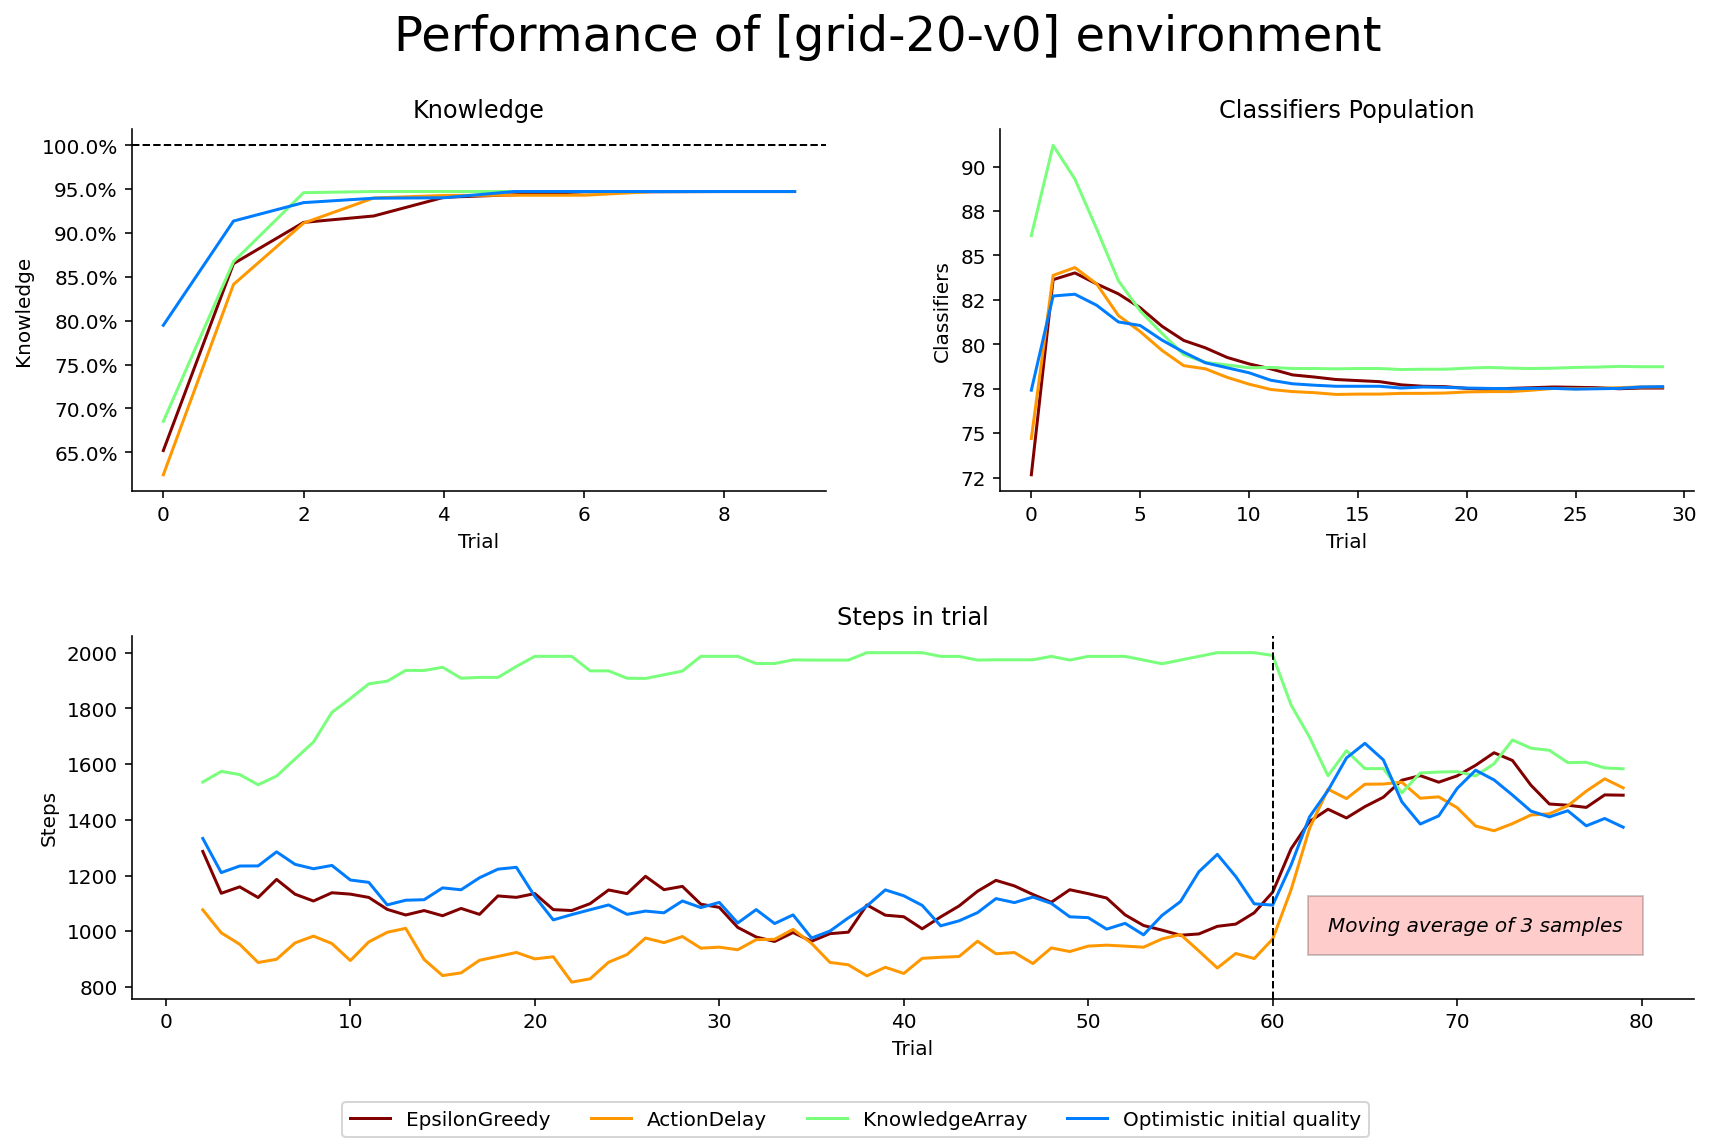

In [16]:
fig = plt.figure(figsize=(14, 8))

# Layout
gs = fig.add_gridspec(2,2, wspace=.25, hspace=.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment', fontsize=24)

# Each axis

# Knowledge
ax1_first = 10  # numer of first trials to show on plot

epsilon_greedy_df['knowledge'][:ax1_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax1)
action_delay_df['knowledge'][:ax1_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax1)
knowledge_array_df['knowledge'][:ax1_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax1)
op_initial_df['knowledge'][:ax1_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Knowledge');
ax1.set_xlabel('Trial')
ax1.set_ylabel('Knowledge')
ax1.axhline(y=100, color='black', linewidth=1, linestyle="--")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())


# Population
ax2_first = 30

epsilon_greedy_df['population'][:ax2_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['population'][:ax2_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['population'][:ax2_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['population'][:ax2_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers')
ax2.set_title('Classifiers Population');
# ax2.set_ylim(17, 40)
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Steps in trial
window = 3 # window for moving average
epsilon_greedy_df['steps_in_trial'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax3)
action_delay_df['steps_in_trial'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax3)
knowledge_array_df['steps_in_trial'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax3)
op_initial_df['steps_in_trial'].rolling(window=window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax3)


ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('Trial')
ax3.set_ylabel('Steps')
ax3.set_title('Steps in trial')
ax3.axvline(x=explore_trials, color='black', linewidth=1, linestyle="--")
ax3.text(63, 1000, f'Moving average of {window} samples', style='italic', bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 10})

# Create legend
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
# fig.savefig('grid-performance.pdf')